In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
import seaborn as sns
import matplotlib as mpl
import scipy.stats as stats

from matplotlib.collections import LineCollection

In [2]:
def euclid(a, b):
    dim = max(len(a.shape), len(b.shape))
    if dim == 1:
        # a, b are just two points
        axis = 0
    elif dim == 2:
        # a and/or b are lists of points
        axis = 1
    else:
        raise ValueError()

    d_squared = np.sum((a - b) ** 2, axis=axis)
    return np.sqrt(d_squared)


def taxicab(a, b):
    return np.sum(np.abs(a - b), axis=1)


def chebyshev(a, b):
    return np.max(np.abs(a - b), axis=1)


def d(a, b):
    """The metric distance between points a and b"""
    a = np.asarray(a)
    b = np.asarray(b)
    return euclid(a, b)


def distances_to_point(p, other_points):
    """Calculates the distance from `p` to all `other_points`"""
    return euclid(p, other_points)


METRIC_NAME = r"\|.\|_\infty"

In [3]:
def to_pivot_space(point, pivots):
    return np.asarray([d(piv, point) for piv in pivots])


def slow_points_to_pivot_space(points, pivots):
    return np.asarray([to_pivot_space(pt, pivots) for pt in points])


def points_to_pivot_space(points, pivots):
    n_points = points.shape[0]
    n_dim = len(pivots)
    transformed = np.empty([n_points, n_dim])
    for dim, pv in enumerate(pivots):
        transformed[:, dim] = distances_to_point(pv, points)
    return transformed

In [4]:
pivots = np.asarray([[-0.5, 0], [0.5, 0]])

In [5]:
def fill_rectangle(x_lim, y_lim, n):
    """Return about `n` points that are inside the given rectangle"""
    samples = int(np.sqrt(n))
    x = np.linspace(*x_lim, samples)
    y = np.linspace(*y_lim, samples)
    xx, yy = np.meshgrid(x, y)
    points = np.array([xx.flatten(), yy.flatten()]).T
    return points

In [6]:
def normal(n=1000):
    return np.random.normal(loc=0.5, scale=0.05, size=n)


circle = np.asarray([0.2 + normal(), 0.2 + normal()]).T

In [7]:
def fill_circle(radius, n):
    bounds = (-radius, radius)
    points = fill_rectangle(bounds, bounds, n)
    distance_to_center = np.sum(points**2, axis=1)
    return points[distance_to_center <= radius**2]


def move_points(points, delta_x, delta_y):
    points = points.copy()
    points[:, 0] += delta_x
    points[:, 1] += delta_y
    return points

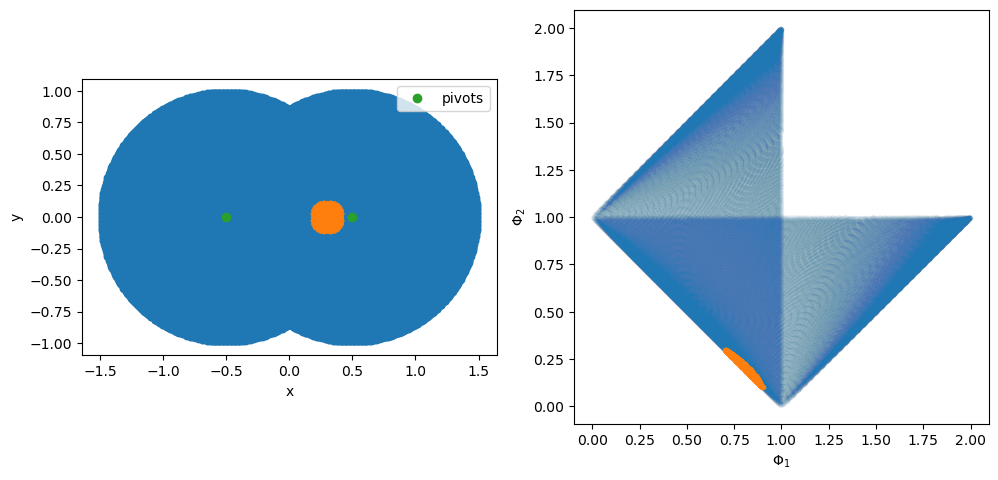

In [8]:
def circle_around_point(radius, point, n):
    c = fill_circle(radius, n)
    return move_points(c, *point)


points = np.vstack([circle_around_point(1, piv, 100000) for piv in pivots])


circle = fill_circle(0.1, 1000)
circle[:, 0] += 0.3

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.xlabel("x")
plt.ylabel("y")

plt.plot(*points.T, ".")
plt.plot(*circle.T, "x")
plt.plot(*pivots.T, "o", label="pivots")
plt.legend()
plt.gca().set_aspect("equal")


plt.subplot(1, 2, 2)
plt.xlabel("$\Phi_1$")
plt.ylabel("$\Phi_2$")

points_piv = points_to_pivot_space(points, pivots)
plt.plot(*points_piv.T, ".", alpha=0.01)
circle_piv = points_to_pivot_space(circle, pivots)
plt.plot(*circle_piv.T, ".")
plt.tight_layout()
plt.gca().set_aspect("equal")

In [9]:
def rot_2d(radians):
    """returns a rotation matrix"""
    rot = R.from_rotvec(np.array([0, 0, radians])).as_matrix()
    rot = rot[0:2, 0:2]
    return rot


def rectify_transform(pivots, points_in_ps):
    """rotates and translates points in the pivots space into a "normal" position."""
    assert len(pivots) == 2, "Not implemented for higher dimensions"
    piv_dist = d(*pivots)
    base_length = np.sqrt(2) * piv_dist
    proj = points_piv - 0.5 * np.array([piv_dist, piv_dist])
    proj = proj @ rot_2d(np.pi / 4)
    proj += np.array([base_length / 2, 0])
    return proj

In [10]:
points = np.vstack([circle_around_point(1, piv, 1000) for piv in pivots])
points = np.unique(points, axis=1)

<bound method Axes.fill_between of <Axes: >>

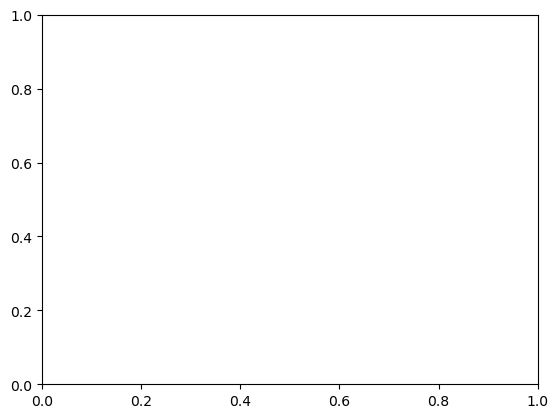

In [11]:
plt.gca().fill_between

(-1.0, 2.0)

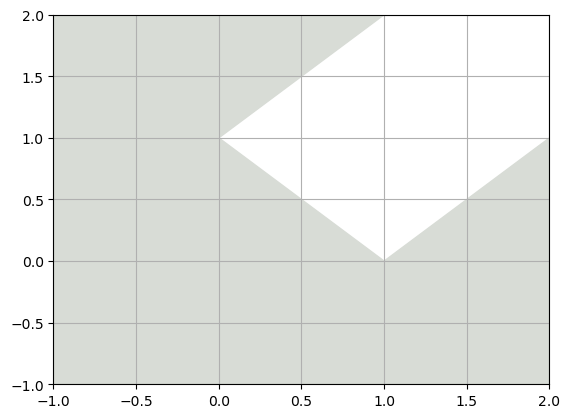

In [12]:
# XXX: refactored to pivot.plot
def mask_forbidden(pivots, ax=None):
    """Plot a gray area where the pivot space is inaccessible.

    This region does not have an preimage, as can easily be seen
    by using the triangle inequality, with both pivots being two
    points of the triangle.
    """
    if ax is None:
        ax = plt.gca()

    def mask(*args, **kwargs):
        return ax.fill_between(
            *args,
            **kwargs,
            color="xkcd:light grey",
        )

    p_1, p_2 = points_to_pivot_space(pivots, pivots)
    b = p_2[0]
    m = -1
    inacc_below = lambda x: m * x + b

    # we don't want to influence the existing limits
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    x = np.linspace(-10, 10)
    y = inacc_below(x)
    mask(x, y, y - 100)

    m = +1
    inacc_above = lambda x: m * x + b
    y = inacc_above(x)
    mask(x, y, y + 100)

    inacc_below = lambda x: m * x - b
    y = inacc_below(x)
    mask(x, y - 100, y)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


mask_forbidden(pivots)
plt.grid()
plt.xlim(-1, 2)
plt.ylim(-1, 2)

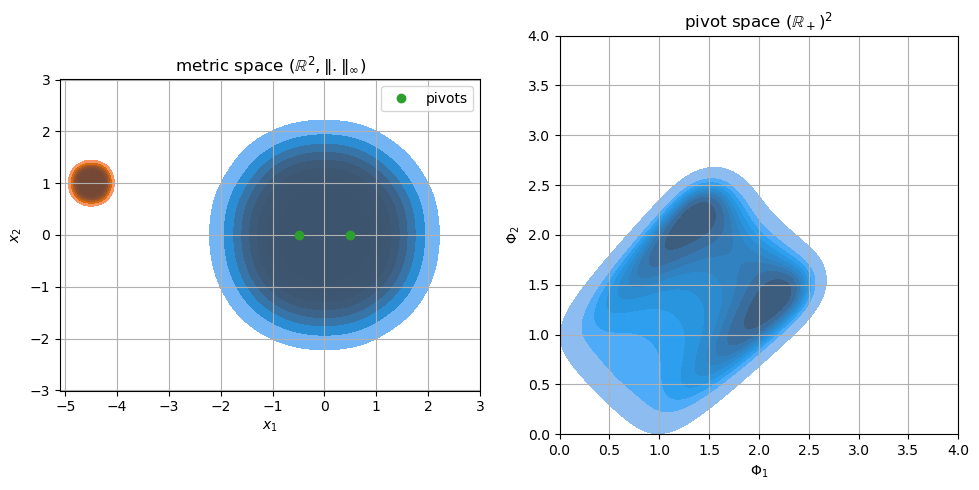

In [13]:
points = fill_circle(2, 1000)  # fill_rectangle((-2,2), (-2,2), 1000)

circle = fill_circle(0.4, 1000)
circle = move_points(circle, -4.5, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(r"metric space $(\mathbb{R}^2, " + METRIC_NAME + ")$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

sns.kdeplot(x=points[:, 0], y=points[:, 1], fill=True)
sns.kdeplot(x=circle[:, 0], y=circle[:, 1], fill=True)
plt.plot(*pivots.T, "C2o", label="pivots")
plt.legend()
plt.gca().set_aspect("equal")
plt.grid()

plt.subplot(1, 2, 2)
plt.title("pivot space $(\mathbb{R}_+)^2$")
plt.xlabel("$\Phi_1$")
plt.ylabel("$\Phi_2$")

#

points_piv = points_to_pivot_space(points, pivots)
sns.kdeplot(x=points_piv[:, 0], y=points_piv[:, 1], fill=True)

circle_piv = points_to_pivot_space(circle, pivots)
plt.plot(*circle_piv.T, "C1o")

# sns.kdeplot(x=circle_piv[:,0], y=circle_piv[:,1], fill=True)

plt.xlim(0, 4)
plt.ylim(0, 4)
# plt.hexbin(*points_piv.T,bins=100)
plt.grid()
plt.tight_layout()
plt.gca().set_aspect("equal")

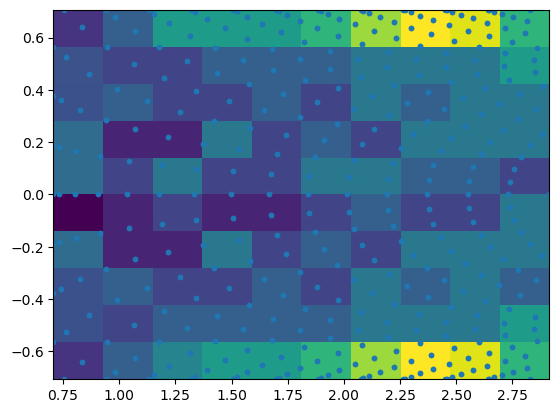

In [14]:
points_rp = rectify_transform(pivots, points_piv)

plt.plot(*points_rp.T, ".", alpha=1)
plt.hist2d(*points_rp.T, density=True);

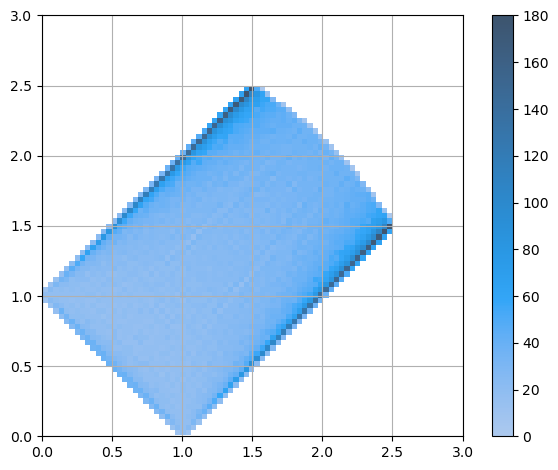

In [15]:
points = fill_circle(2, 100000)

# mask_forbidden(pivots)

points_piv = points_to_pivot_space(points, pivots)
# sns.kdeplot(x=points_piv[:,0], y=points_piv[:,1], fill=True)

circle_piv = points_to_pivot_space(circle, pivots)
plt.plot(*circle_piv.T, "C1o")

# sns.kdeplot(x=circle_piv[:,0], y=circle_piv[:,1], fill=True)

# plt.hist2d(*points_piv.T,bins=[100,100])
sns.histplot(x=points_piv[:, 0], y=points_piv[:, 1], cbar=True)

plt.xlim(0, 3)
plt.ylim(0, 3)

plt.grid()
plt.tight_layout()
plt.gca().set_aspect("equal")

In [16]:
points = stats.multivariate_normal(mean=[0, 0]).rvs(10_000_000)
points_piv = points_to_pivot_space(points, pivots)
points_rp = rectify_transform(pivots, points_piv)

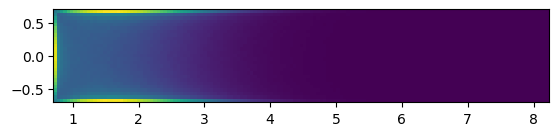

In [17]:
def binspace(vals, bin_length=0.05):
    """generates bin edges that are guaranteed to be between vals.min and vals.max
    The actual bin_length can be off by a little bit to accomplish this."""
    space = vals.max() - vals.min()
    steps = int(space / bin_length)
    return np.linspace(vals.min(), vals.max() + 1e-6, steps)


bins = binspace(points_rp[:, 0]), binspace(points_rp[:, 1])

plt.hist2d(*points_rp.T, bins=bins, density=True)  # , norm=mpl.colors.LogNorm());
plt.gca().set_aspect("equal")
plt.show()

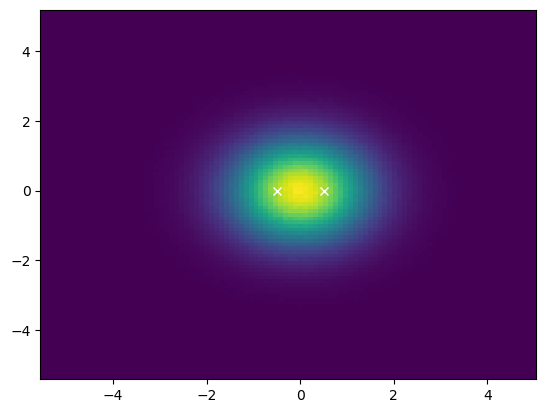

In [18]:
plt.hist2d(*points.T, bins=100)
plt.plot(*pivots.T, "x", color="white", label="pivots");